# DENOISING AUTO-ENCODER

In [1]:
# from https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist_dropout.ipynb
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
#from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


In [30]:
#!/usr/bin/env python
# ====================
#  MORSE DATA GENERATOR
# ====================
class Morse():
    def __init__(self, n_samples=1000, max_seq_len=784, min_seq_len=4, filename=None):
        """ Generate sequence of Morse data with MNIST format.
        MNIST dataset consists of: 
        training: (55000, 28, 28, 1) (55000, 10)
        validation: (5000, 28, 28, 1) (5000, 10)
        test: (10000, 28, 28, 1) (10000, 10)
        Need text file with > 70,000 characters 
        This class generates samples for training:
        - Morse char A: sequence (i.e. [1, 0, 1, 1, 1, 0, 0, 0,...])
        - Morse char B: sequences (i.e. [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,...])

        NOTICE:
        We have to pad each sequence to reach 784  (28x28) size.
        """
        self.Morsecode = {
             '!': '-.-.--',
             '$': '...-..-',
             "'": '.----.',
             '(': '-.--.',
             ')': '-.--.-',
             ',': '--..--',
             '-': '-....-',
             '.': '.-.-.-',
             '/': '-..-.',
             '0': '-----',
             '1': '.----',
             '2': '..---',
             '3': '...--',
             '4': '....-',
             '5': '.....',
             '6': '-....',
             '7': '--...',
             '8': '---..',
             '9': '----.',
             ':': '---...',
             ';': '-.-.-.',
             '>': '.-.-.',     #<AR>
             '<': '.-...',     # <AS>
             '{': '....--',    #<HM>
             '&': '..-.-',     #<INT>
             '%': '...-.-',    #<SK>
             '}': '...-.',     #<VE>
             '=': '-...-',     #<BT>
             '?': '..--..',
             '@': '.--.-.',
             'A': '.-',
             'B': '-...',
             'C': '-.-.',
             'D': '-..',
             'E': '.',
             'F': '..-.',
             'G': '--.',
             'H': '....',
             'I': '..',
             'J': '.---',
             'K': '-.-',
             'L': '.-..',
             'M': '--',
             'N': '-.',
             'O': '---',
             'P': '.--.',
             'Q': '--.-',
             'R': '.-.',
             'S': '...',
             'T': '-',
             'U': '..-',
             'V': '...-',
             'W': '.--',
             'X': '-..-',
             'Y': '-.--',
             'Z': '--..',
             '\\': '.-..-.',
             '_': '..--.-',
             '~': '.-.-',
             ' ': '_'}

        # read file containing training or test text
        if filename: 
            f = open(filename,'r')
            self.text = f.read()
            f.close()
            self._data = []
            self._labels = []
            self.seqlen = []
            self.num_examples = n_samples
            # Read characters, encode to data vector and
            # append data and class labels
            # save also sequence length
            for i in range(n_samples):
                ch = self.text[i]
                #print( ch)
                s,length = self.encode_data(ch)
                s += [[0.0] for i in range(max_seq_len - length)]
                self._data.append(s)
                self._labels.append(self.class_labels(ch))
                self.seqlen.append(length)
            
        self.batch_id = 0    

    def images(self):
        return np.array(self._data).reshape(self.num_examples,28,28,1)
    
    def labels(self):
        return np.array(self._labels).reshape(self.num_examples,len(self.Morsecode))
    
    def encode_morse(self, cws):
        """Return encoded string of symbols from Morse code book.
           Symbols: 
            dit='.'
            dah='-'
            whitespace = '_'
        """
        s=[]
        for chr in cws:
            try: # try to find CW sequence from Codebook
                s += self.Morsecode[chr]
                if chr != ' ':
                    s += ' '
            except:
                if chr == ' ' or chr =='\n':
                    s += '_'
                    continue
                print ("error: %s not in Codebook" % chr)
        return ''.join(s)

    def len_chr(self, ch):
        s = self.Morsecode[ch]
        return len_dits(s)

    def len_dits(cws):
        """Return the length of CW string in dit units, including spaces. """
        val = 0
        for ch in cws:
            if ch == '.': # dit len + el space 
                val += 2
            if ch == '-': # dah len + el space
                val += 4
            if ch==' ':   #  char space
                val += 2
            if ch=='_':   #  word space
                val += 6
        return val

    def encode_data(self, ch):
        """ Return encoded list of dit/dah values based on Morse Coodebook."""
        data = []
        s = ''
        try:
            s = self.Morsecode[ch]
            if ch != ' ':
                s += ' '
            #print(s)
        except:
            if ch == ' ' or ch =='\n':
                s += '_'
            print ("error: %s not in Codebook" % ch)
        for i in s:
            if i == '.': # dit followed by ele space
                data += [[.99],[0.]]
            if i == '-': # dah followed by ele space
                data += [[.99],[.99],[.99],[0.]]
            if i ==' ':   #  char space 2 (+1 ele space after dit or dah)
                data += [[0.],[0.]]
            if i =='_':   #  word space 6 
                data += [[0.],[0.],[0.],[0.],[0.],[0.]]
        return data, len(data)

    def class_labels(self, ch):
        """ Return on-hot-encoded class label for a given Morse character.
        """
        label = [0.] * len(self.Morsecode)
        try:
            e = list(self.Morsecode.keys()).index(ch)
            label[e] = 1.
            return label
        except:
            return label

    def decode(self, pos):
        """ Return character in position pos in the Morse Codebook, 
            or * if doesn't exist in the Codebook.
        """
        try:
            return self.Morsecode.keys()[pos]
        except:
            return '*'

    def number_of_classes(self):
        """ Return number of characters in the Morse codebook."""
        return len(self.Morsecode)

    def next(self, batch_size):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.batch_id == len(self._data):
            self.batch_id = 0
        batch_data = (self._data[self.batch_id:min(self.batch_id + batch_size, len(self._data))])
        batch_labels = (self.labels[self.batch_id:min(self.batch_id + batch_size, len(self._data))])
        batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id + batch_size, len(self._data))])
        self.batch_id = min(self.batch_id + batch_size, len(self._data))
        return batch_data, batch_labels, batch_seqlen


In [50]:
from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.platform import gfile
import gzip
import numpy
from tensorflow.python.framework import random_seed
import collections

DEFAULT_SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

Dataset = collections.namedtuple('Dataset', ['data', 'target'])
Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test'])


def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(f):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
  Args:
    f: A file object that can be passed into a gzip reader.
  Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].
  Raises:
    ValueError: If the bytestream does not start with 2051.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, f.name))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


def dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


def extract_labels(f, one_hot=False, num_classes=10):
  """Extract the labels into a 1D uint8 numpy array [index].
  Args:
    f: A file object that can be passed into a gzip reader.
    one_hot: Does one hot encoding for the result.
    num_classes: Number of classes for the one hot encoding.
  Returns:
    labels: a 1D uint8 numpy array.
  Raises:
    ValueError: If the bystream doesn't start with 2049.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                       (magic, f.name))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return dense_to_one_hot(labels, num_classes)
    return labels

class MorseDataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True,
               seed=None):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        #images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)
      ]
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part), axis=0) , numpy.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir,
                   fake_data=False,
                   one_hot=False,
                   dtype=dtypes.float32,
                   reshape=True,
                   validation_size=5000,
                   seed=None,
                   source_url=DEFAULT_SOURCE_URL):
  if fake_data:

    def fake():
      return MorseDataSet(
          [], [], fake_data=True, one_hot=one_hot, dtype=dtype, seed=seed)

    train = fake()
    validation = fake()
    test = fake()
    return Datasets(train=train, validation=validation, test=test)

  if not source_url:  # empty string check
    source_url = DEFAULT_SOURCE_URL

  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

  local_file = base.maybe_download(TRAIN_IMAGES, train_dir,
                                   source_url + TRAIN_IMAGES)
  with gfile.Open(local_file, 'rb') as f:
    train_images = extract_images(f)

  local_file = base.maybe_download(TRAIN_LABELS, train_dir,
                                   source_url + TRAIN_LABELS)
  with gfile.Open(local_file, 'rb') as f:
    train_labels = extract_labels(f, one_hot=one_hot)

  local_file = base.maybe_download(TEST_IMAGES, train_dir,
                                   source_url + TEST_IMAGES)
  with gfile.Open(local_file, 'rb') as f:
    test_images = extract_images(f)

  local_file = base.maybe_download(TEST_LABELS, train_dir,
                                   source_url + TEST_LABELS)
  with gfile.Open(local_file, 'rb') as f:
    test_labels = extract_labels(f, one_hot=one_hot)

  if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))

  validation_images = train_images[:validation_size]
  validation_labels = train_labels[:validation_size]
  train_images = train_images[validation_size:]
  train_labels = train_labels[validation_size:]


  options = dict(dtype=dtype, reshape=reshape, seed=seed)

  print "SHAPE:",train_images.shape,train_labels.shape 
  print "SHAPE:",validation_images.shape,validation_labels.shape 
  print "SHAPE:",test_images.shape,test_labels.shape 

  # Need 55,000  28x28x1 images  and labels 
    
  train = MorseDataSet(train_images, train_labels, **options)
  validation = MorseDataSet(validation_images, validation_labels, **options)
  test = MorseDataSet(test_images, test_labels, **options)

  return Datasets(train=train, validation=validation, test=test)

#mnist = read_data_sets('data/', one_hot=True)
#from  matplotlib.pyplot import imshow 
#imshow( mnist.train.images[0].reshape(28,28))

# MORSE - MNIST

In [5]:
#mnist = # Create a training set from 'strings.txt' file 
def generate_datasets():
    m = Morse(55000, filename='strings.txt')
    train_images = m.images()
    train_labels = m.labels()
    train = MorseDataSet(images=train_images, labels=train_labels)
    
    m = Morse(5000, filename='strings.txt')
    validation_images=m.images()
    validation_labels=m.labels()
    validation = MorseDataSet(images=validation_images, labels=validation_labels)
    
    m = Morse(10000, filename='strings.txt')
    test_images = m.images()
    test_labels = m.labels()
    test = MorseDataSet(images=test_images, labels=test_labels)
    return Datasets(train=train, validation=validation, test=test)


mnist = generate_datasets()
print ("MORSE TRAINING & TESTING MATERIALS GENERATED")

MORSE TRAINING & TESTING MATERIALS GENERATED


In [6]:
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("TRAINING & TESTING MATERIALS READY")

TRAINING & TESTING MATERIALS READY


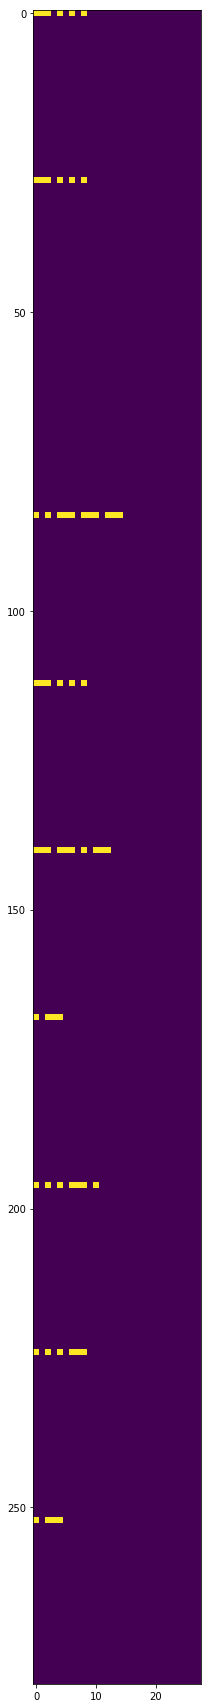

In [7]:
# Check that we got the right image format
from  matplotlib.pyplot import imshow, show, figure, plot
figure(figsize=(3,300))
imshow(mnist.train.images[0:10].reshape(280,28))

# DEVICE TO USE

In [8]:
device2use = "/cpu:0"

# DEFINE NETWORK

In [9]:
# Network Parameters
n_input    = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 256 # 2nd layer num features
n_output   = 784 # 
with tf.device(device2use):
    # tf Graph input
    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_output])
    dropout_keep_prob = tf.placeholder("float")
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_output]))
    }

In [10]:
with tf.device(device2use):
    # Create model
    def denoising_autoencoder(_X, _weights, _biases, _keep_prob):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
        layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['h2']), _biases['b2'])) 
        layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
        return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])
print ("NETWORK READY")

NETWORK READY


# DEFINE FUNCTIONS

In [11]:
with tf.device(device2use):
    # MODEL
    out = denoising_autoencoder(x, weights, biases, dropout_keep_prob)
    # DEFINE LOSS AND OPTIMIZER
    cost = tf.reduce_mean(tf.pow(out-y, 2))
     
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 
    # INITIALIZE
    init = tf.initialize_all_variables()
    # SAVER
    savedir = "nets/"
    saver = tf.train.Saver(max_to_keep=3) 
print ("FUNCTIONS READY")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
FUNCTIONS READY


# OPTIMIZE 

In [12]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True))
sess.run(init)

START OPTIMIZATION
Epoch: 000/300 cost: 0.002826577
Time 5.8 secs


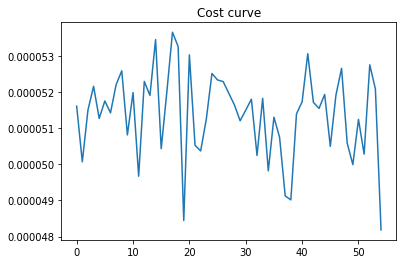

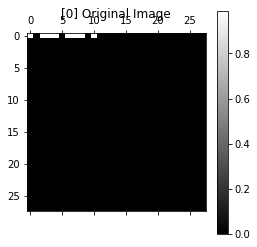

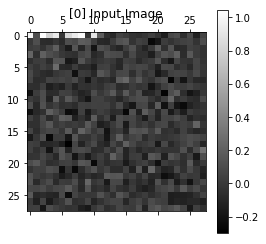

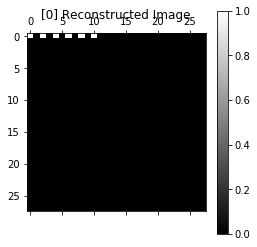

Epoch: 005/300 cost: 0.002835817
Time 35.6 secs
Epoch: 010/300 cost: 0.002847279
Time 65.3 secs


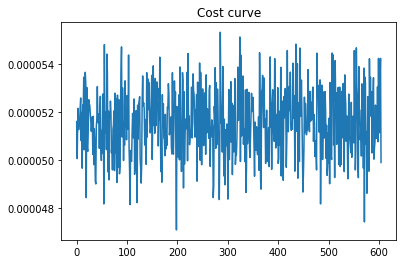

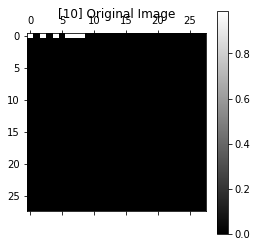

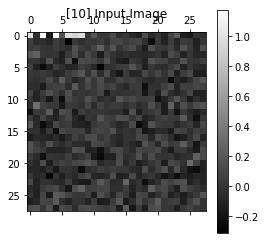

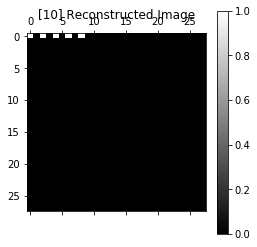

Epoch: 015/300 cost: 0.002828666
Time 97.7 secs
Epoch: 020/300 cost: 0.002834426
Time 128.1 secs


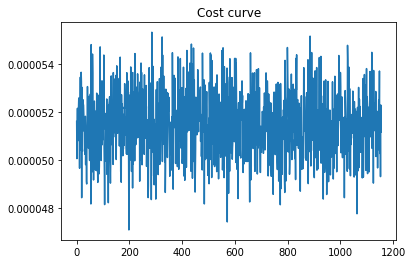

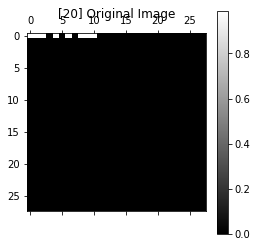

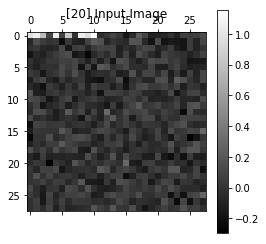

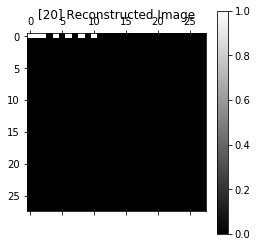

Epoch: 025/300 cost: 0.002821313
Time 158.3 secs
Epoch: 030/300 cost: 0.002515623
Time 187.2 secs


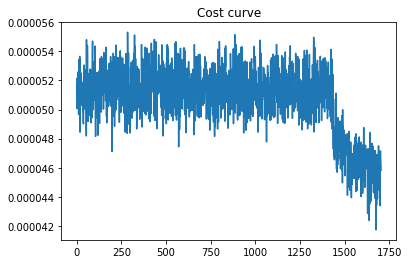

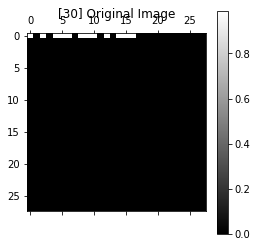

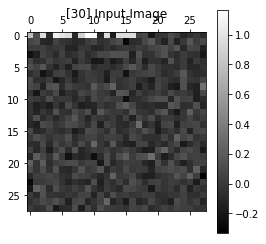

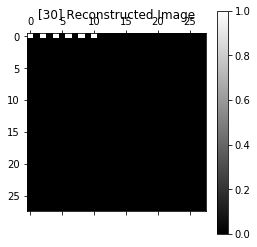

Epoch: 035/300 cost: 0.002495198
Time 217.1 secs
Epoch: 040/300 cost: 0.002510772
Time 247.4 secs


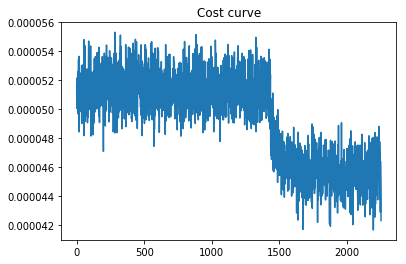

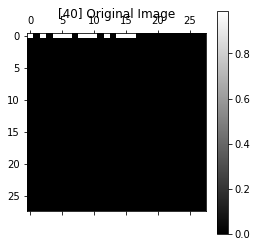

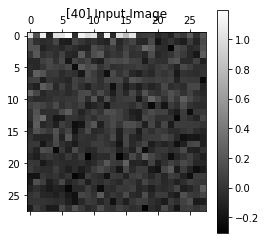

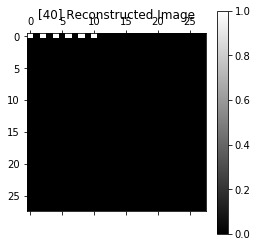

Epoch: 045/300 cost: 0.002500246
Time 277.4 secs
Epoch: 050/300 cost: 0.002510507
Time 306.9 secs


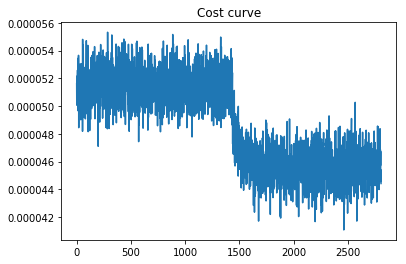

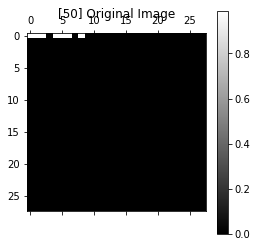

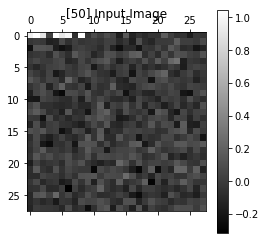

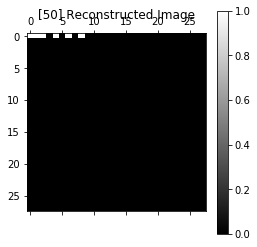

Epoch: 055/300 cost: 0.002523813
Time 337.1 secs
Epoch: 060/300 cost: 0.002212413
Time 366.0 secs


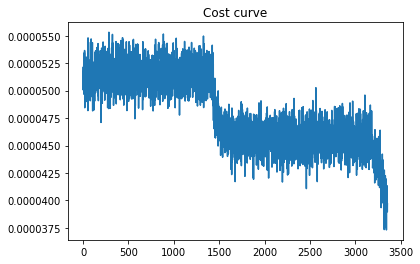

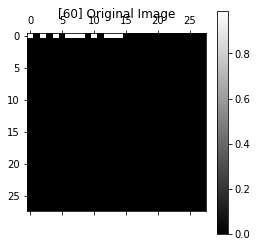

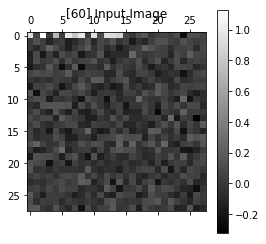

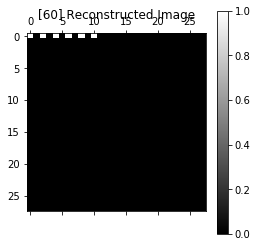

Epoch: 065/300 cost: 0.002176061
Time 395.8 secs
Epoch: 070/300 cost: 0.002167254
Time 424.6 secs


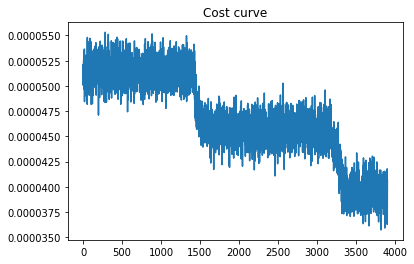

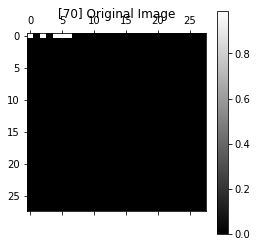

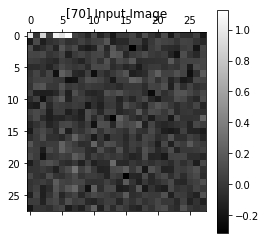

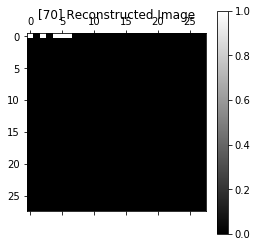

Epoch: 075/300 cost: 0.002174883
Time 454.5 secs
Epoch: 080/300 cost: 0.001964620
Time 483.4 secs


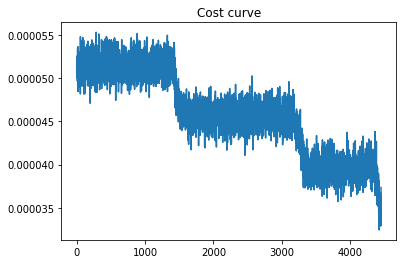

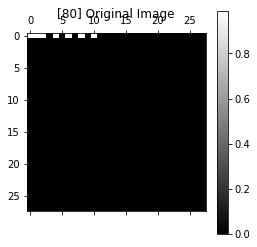

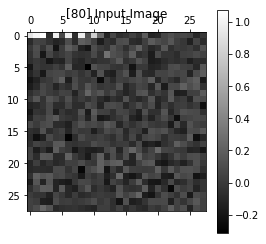

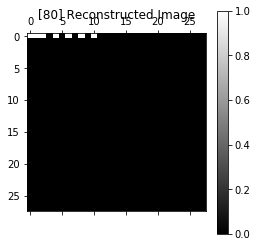

Epoch: 085/300 cost: 0.001882178
Time 513.4 secs
Epoch: 090/300 cost: 0.001480428
Time 542.2 secs


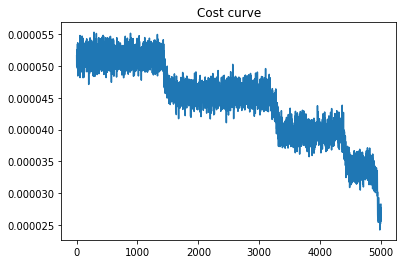

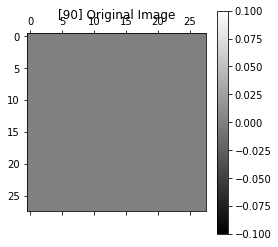

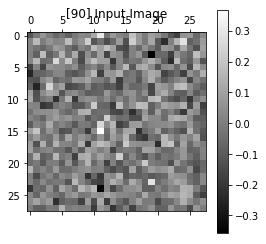

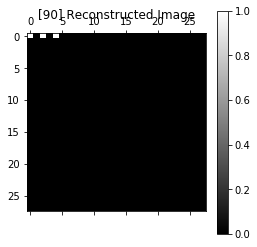

Epoch: 095/300 cost: 0.001409836
Time 572.2 secs
Epoch: 100/300 cost: 0.001402940
Time 601.1 secs


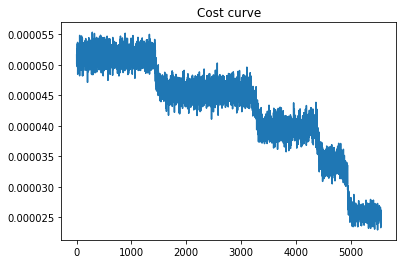

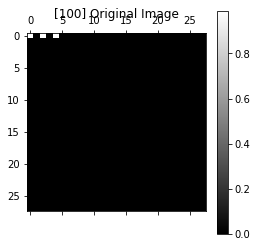

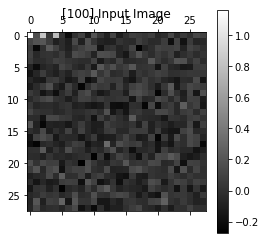

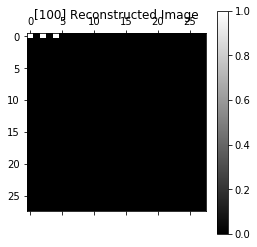

Epoch: 105/300 cost: 0.001408896
Time 630.9 secs
Epoch: 110/300 cost: 0.001304686
Time 659.8 secs


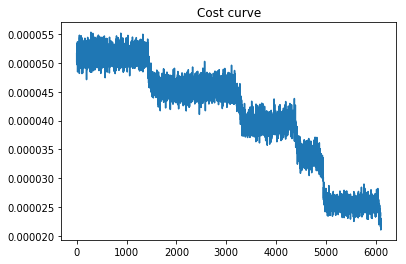

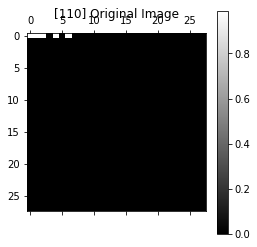

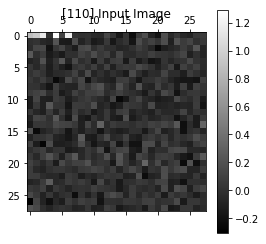

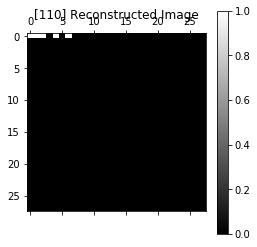

Epoch: 115/300 cost: 0.001028561
Time 689.8 secs
Epoch: 120/300 cost: 0.000952013
Time 718.6 secs


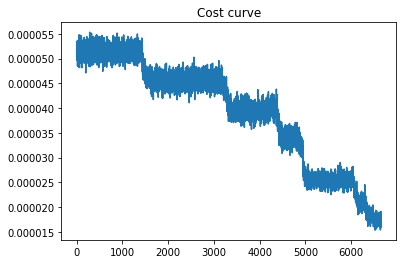

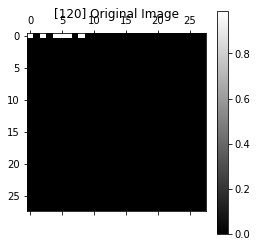

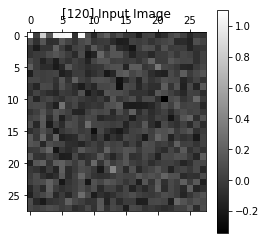

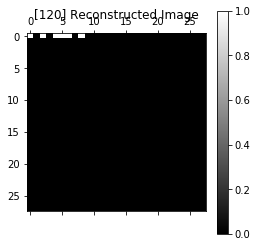

Epoch: 125/300 cost: 0.000937970
Time 748.5 secs
Epoch: 130/300 cost: 0.000941086
Time 777.5 secs


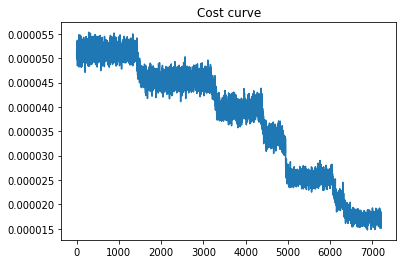

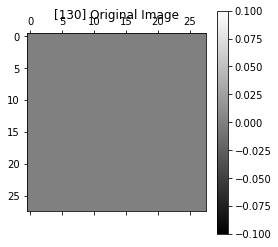

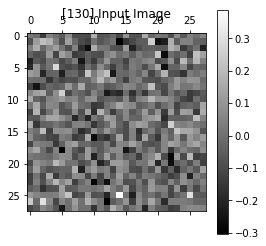

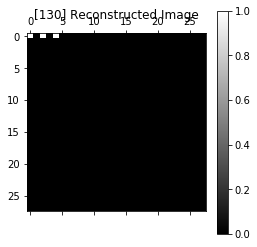

Epoch: 135/300 cost: 0.000942552
Time 807.4 secs
Epoch: 140/300 cost: 0.000944997
Time 836.3 secs


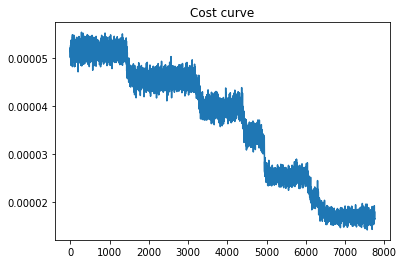

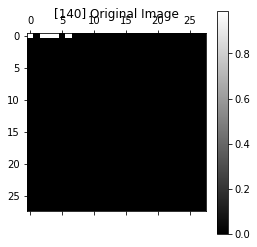

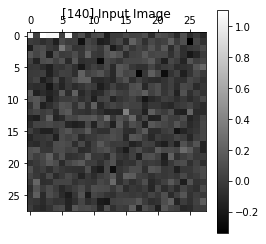

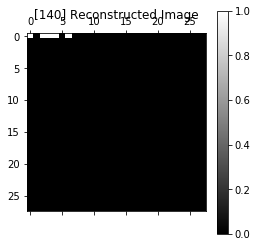

Epoch: 145/300 cost: 0.000939699
Time 866.0 secs
Epoch: 150/300 cost: 0.000934855
Time 895.9 secs


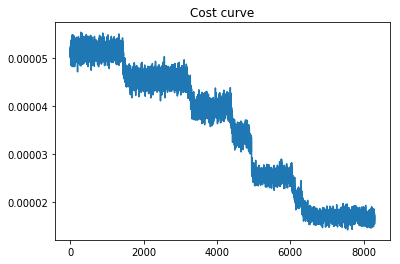

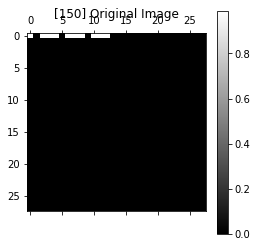

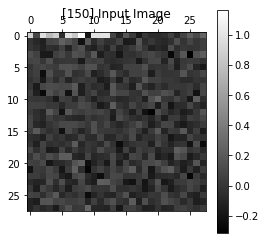

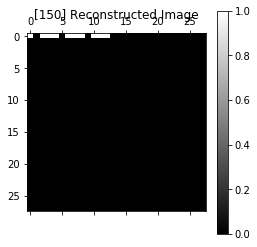

Epoch: 155/300 cost: 0.000950536
Time 927.6 secs
Epoch: 160/300 cost: 0.000949863
Time 957.7 secs


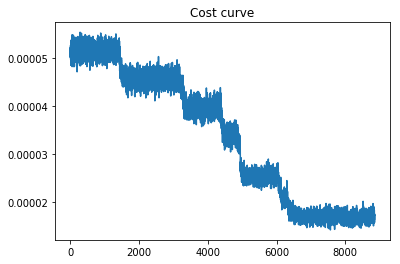

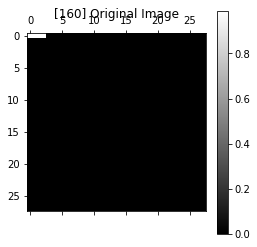

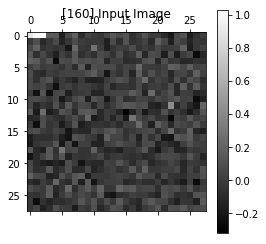

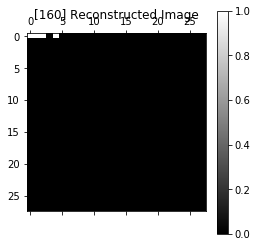

Epoch: 165/300 cost: 0.000924307
Time 989.6 secs
Epoch: 170/300 cost: 0.000944627
Time 1020.1 secs


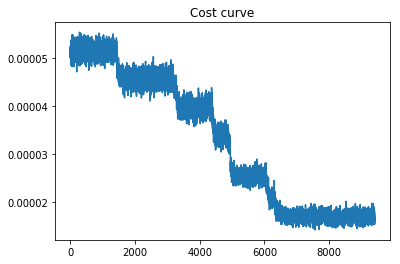

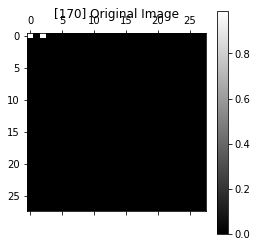

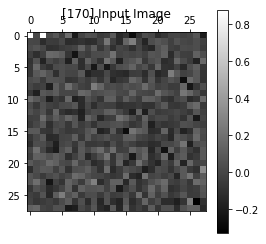

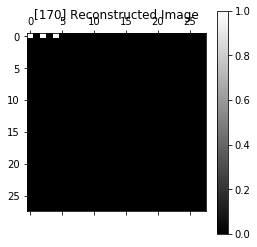

Epoch: 175/300 cost: 0.000927778
Time 1050.6 secs
Epoch: 180/300 cost: 0.000935188
Time 1079.6 secs


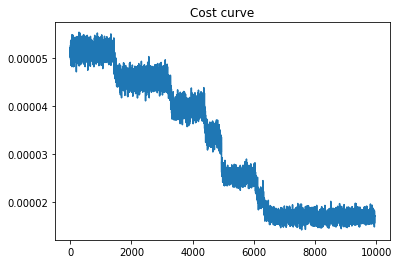

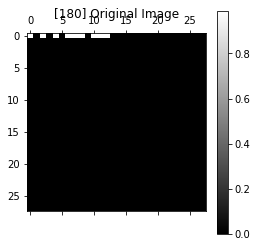

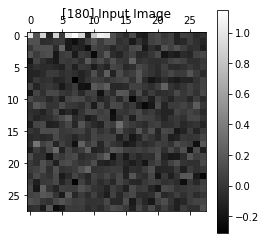

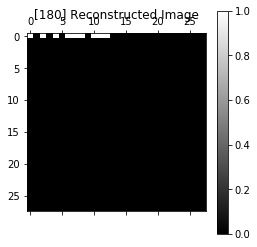

Epoch: 185/300 cost: 0.000946448
Time 1109.5 secs
Epoch: 190/300 cost: 0.000936092
Time 1138.4 secs


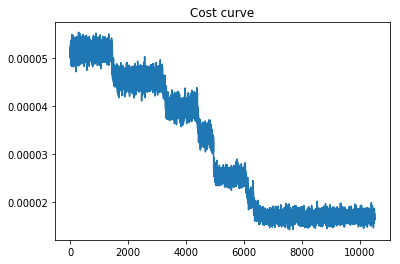

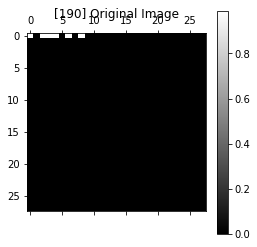

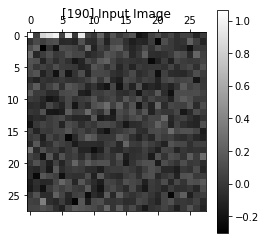

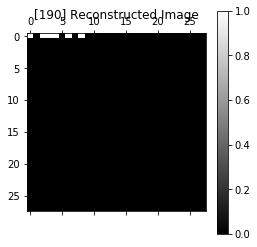

Epoch: 195/300 cost: 0.000935925
Time 1168.3 secs
Epoch: 200/300 cost: 0.000929401
Time 1199.3 secs


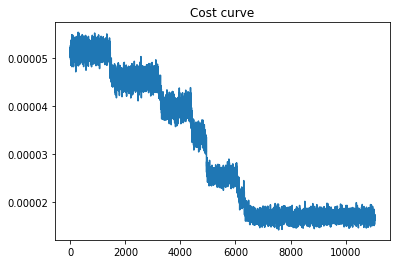

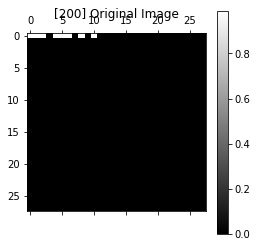

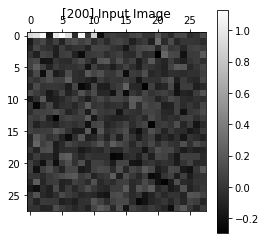

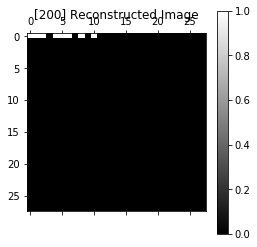

Epoch: 205/300 cost: 0.000932923
Time 1229.1 secs
Epoch: 210/300 cost: 0.000932811
Time 1259.7 secs


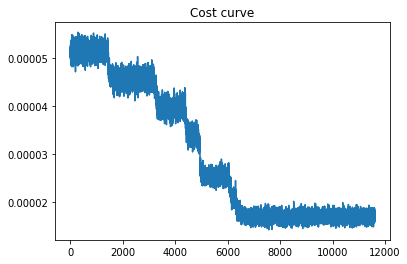

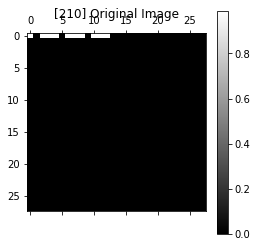

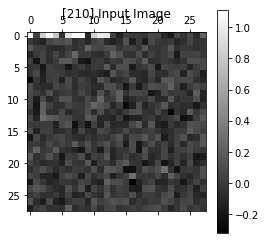

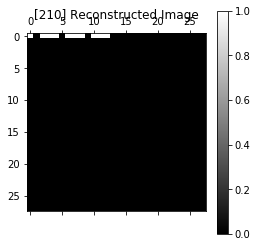

Epoch: 215/300 cost: 0.000929157
Time 1290.6 secs
Epoch: 220/300 cost: 0.000933604
Time 1319.5 secs


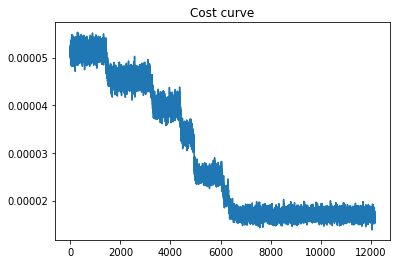

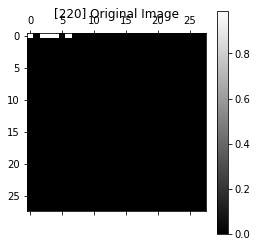

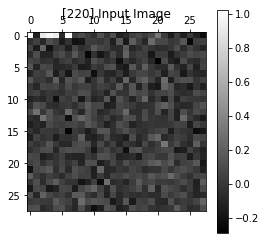

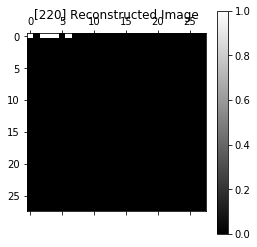

Epoch: 225/300 cost: 0.000883392
Time 1349.3 secs
Epoch: 230/300 cost: 0.000862141
Time 1378.8 secs


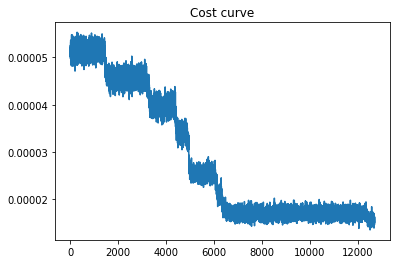

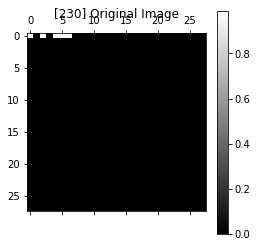

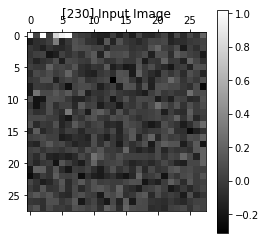

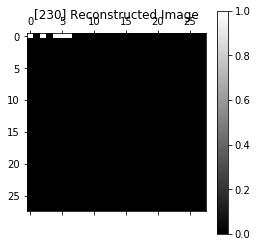

Epoch: 235/300 cost: 0.000857643
Time 1409.9 secs
Epoch: 240/300 cost: 0.000856304
Time 1440.8 secs


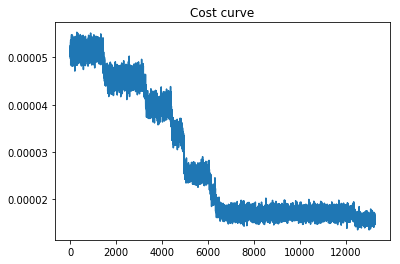

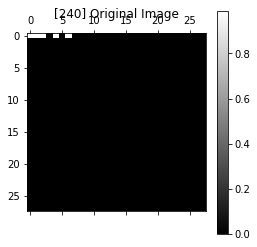

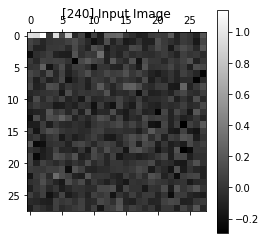

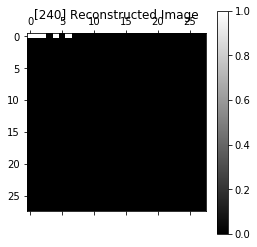

Epoch: 245/300 cost: 0.000854603
Time 1472.7 secs
Epoch: 250/300 cost: 0.000859479
Time 1503.5 secs


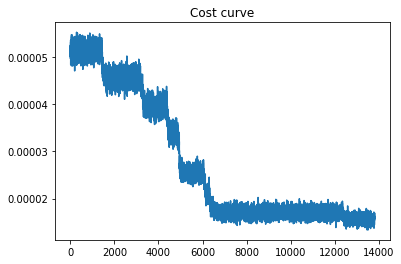

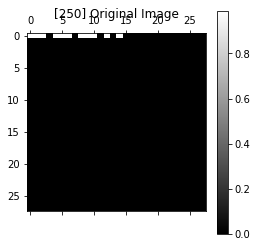

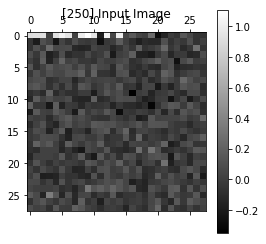

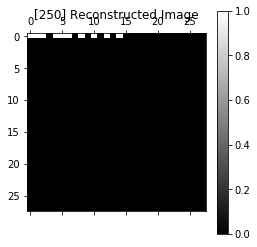

Epoch: 255/300 cost: 0.000662139
Time 1534.5 secs
Epoch: 260/300 cost: 0.000661839
Time 1564.8 secs


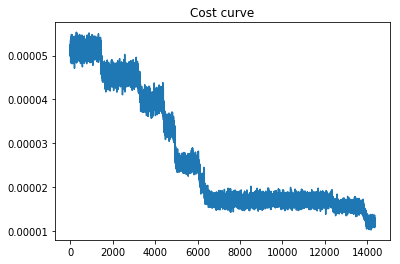

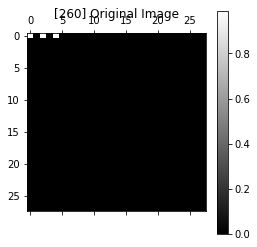

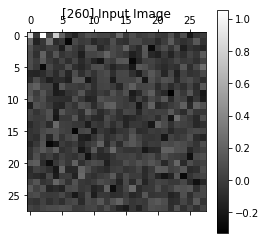

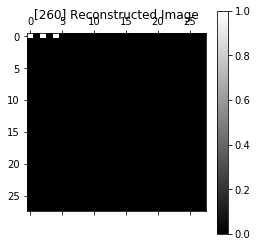

Epoch: 265/300 cost: 0.000659176
Time 1597.2 secs
Epoch: 270/300 cost: 0.000659524
Time 1628.0 secs


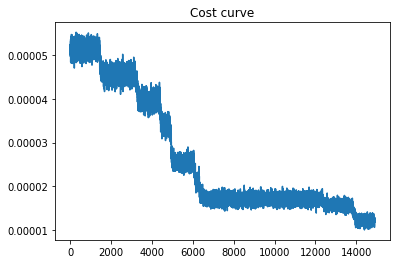

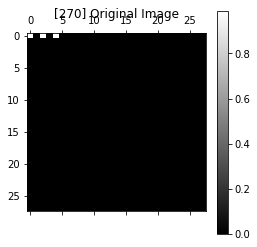

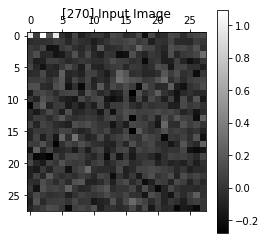

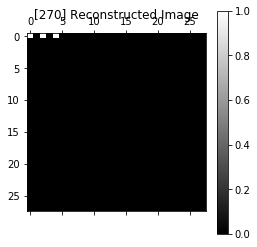

Epoch: 275/300 cost: 0.000663658
Time 1660.4 secs
Epoch: 280/300 cost: 0.000660484
Time 1689.9 secs


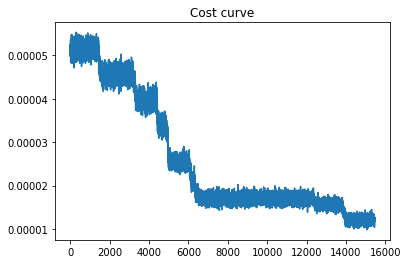

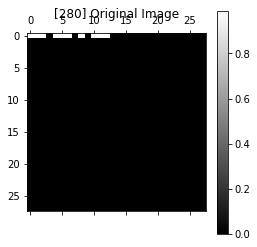

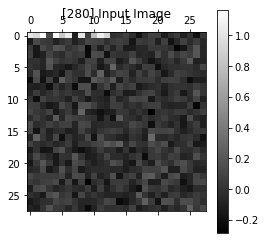

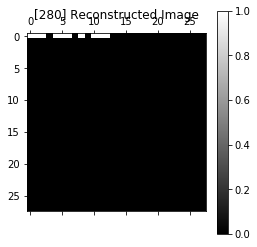

Epoch: 285/300 cost: 0.000658322
Time 1720.6 secs
Epoch: 290/300 cost: 0.000664883
Time 1750.8 secs


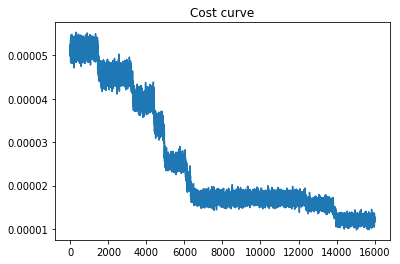

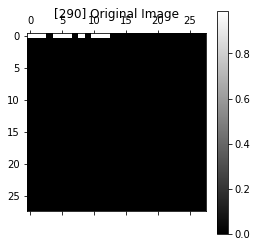

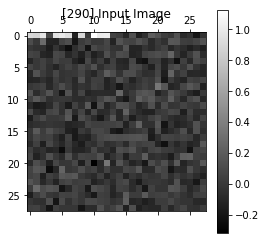

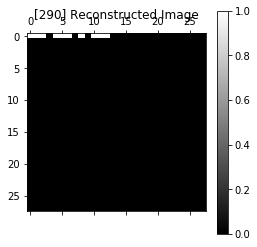

Epoch: 295/300 cost: 0.000661133
Time 1780.8 secs


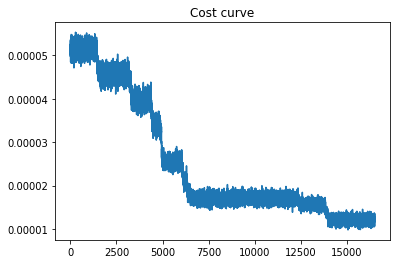

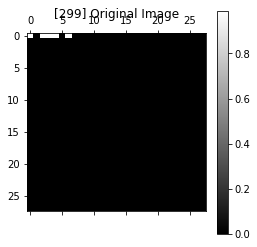

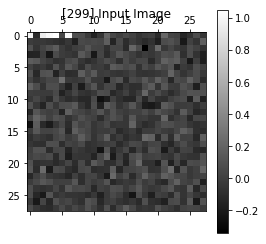

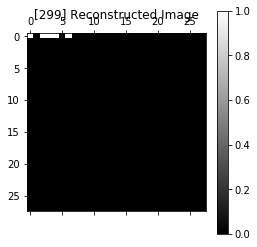

Optimization Finished!
('Training duration:', '1804.9 secs')


In [19]:
import time

training_epochs = 300
batch_size      = 1000
display_step    = 5
plot_step       = 10
if do_train:
    print ("START OPTIMIZATION")
    start = time.time()
    pcost = []
    for epoch in range(training_epochs):
        avg_cost = 0.
        num_batch = int(mnist.train.num_examples/batch_size)
        for i in range(num_batch): 
            randidx = np.random.randint(trainimg.shape[0], size=batch_size)
            batch_xs = trainimg[randidx, :]
            batch_xs_noisy = batch_xs + 0.1*np.random.randn(batch_xs.shape[0], 784)
            feed1 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 0.5}
            sess.run(optimizer, feed_dict=feed1)
            feed2 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1}
            c = sess.run(cost, feed_dict=feed2)/num_batch
            avg_cost += c
            pcost.append(c)

        # DISPLAY
        if epoch % display_step == 0:
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            print ("Time {:.1f} secs".format(time.time()-start))
            
        if epoch % plot_step == 0 or epoch == training_epochs-1:
            # TEST
            randidx  = np.random.randint(testimg.shape[0], size=1)
            testvec  = testimg[randidx, :]
            noisyvec = testvec + 0.1*np.random.randn(1, 784)
            outvec   = sess.run(out, feed_dict={x: testvec, dropout_keep_prob: 1.})
            outimg   = np.reshape(outvec, (28, 28))
            feed2 = {x: testvec, y: outvec, dropout_keep_prob: 1}
             
            # PLOT 
            plt.plot(pcost)
            plt.title("Cost curve")
            plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Original Image")
            plt.colorbar()
            plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Input Image")
            plt.colorbar()
            plt.matshow(outimg, cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Reconstructed Image")
            plt.colorbar()
            plt.show()

            # SAVE
            saver.save(sess, savedir + 'dae_dr.ckpt', global_step=epoch)
            
    print ("Optimization Finished!")
    stop = time.time()
    print ("Training duration:","{:.1f} secs".format(stop-start))
else:
    print ("RESTORE")
    saver.restore(sess, "nets/dae_dr.ckpt-" + str(training_epochs-1))

# TEST

[2324]
label is Y (key:56)
Gaussian Noise


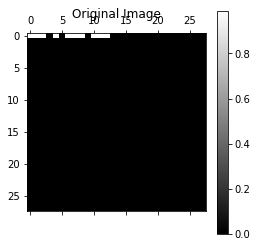

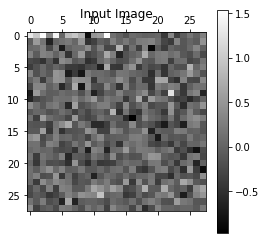

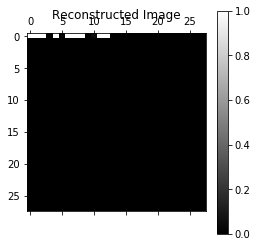

In [49]:
randidx   = np.random.randint(testimg.shape[0], size=1)
print randidx
orgvec    = testimg[randidx, :]
testvec   = testimg[randidx, :]
label     = np.argmax(testlabel[randidx, :], 1)

m = Morse()

print ("label is %s (key:%d)" % (m.decode(int(label)),label))
# Noise type
ntype = 1 # 1: Gaussian Noise, 2: Salt and Pepper Noise
if ntype is 1:
    print ("Gaussian Noise")
    noisyvec = testvec + 0.3*np.random.randn(1, 784)
else:    
    print ("Salt and Pepper Noise")
    noisyvec = testvec
    rate     = 0.20
    noiseidx = np.random.randint(testimg.shape[1], size=int(testimg.shape[1]*rate))
    noisyvec[0, noiseidx] = 1-noisyvec[0, noiseidx]

outvec   = sess.run(out, feed_dict={x: noisyvec, dropout_keep_prob: 1})
outimg   = np.reshape(outvec, (28, 28))

# Plot 
plt.matshow(np.reshape(orgvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Original Image")
plt.colorbar()

plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Input Image")
plt.colorbar()

plt.matshow(outimg, cmap=plt.get_cmap('gray'))
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

# PLOT FILTER SHAPES

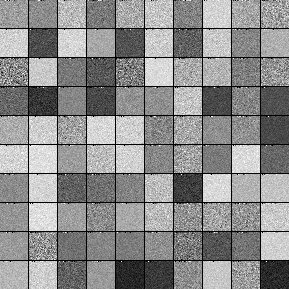

In [48]:
# Visualize Filter 
from PIL import Image

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                    else:
                        this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    out_array[
                        tile_row * (H+Hs): tile_row * (H + Hs) + H,
                        tile_col * (W+Ws): tile_col * (W + Ws) + W
                        ] \
                        = this_img * (255 if output_pixel_vals else 1)
        return out_array

# Visualize filter
w1 = sess.run(weights["h1"])

image = Image.fromarray(tile_raster_images(
        X = w1.T,
        img_shape=(28, 28), tile_shape=(10, 10),
        tile_spacing=(1, 1)))
image